In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
# 设置字体
plt.rcParams['font.family'] = 'SimHei'  # 使用黑体字体，或选择其他支持中文的字体

In [3]:
df_economy = pd.read_csv("..\data\\all_countries_combined.csv")
df_economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245 entries, 0 to 10244
Data columns (total 21 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   Country                                                                                   10245 non-null  object 
 1   Year                                                                                      10245 non-null  int64  
 2   Population                                                                                10245 non-null  int64  
 3   Per capita GNI                                                                            10245 non-null  int64  
 4   Agriculture, hunting, forestry, fishing (ISIC A-B)                                        10245 non-null  float64
 5   Construction (ISIC F)                                

In [4]:
def get_year_df(df_economy, left_year, right_year, with_year=False):
    # 先筛选 1992 年及以后的数据
    df_select = df_economy[(df_economy['Year'] >= left_year) & (df_economy['Year'] <= right_year)]

    # 然后按 Country 分组，计算均值（默认对数值型列计算均值）
    country_mean = df_select.groupby('Country').mean(numeric_only=True)

    # 如果你想保留国家名作为列，而不是索引，可以 reset_index()
    country_mean = country_mean.reset_index()
    if not with_year:
        country_mean = country_mean.drop(columns="Year")
    
    # 查看结果
    # print(len(country_mean))
    # print(country_mean.head())
    
    return country_mean

def get_X_scale(df_economy, left_year, right_year, with_year=False):
    country_mean = get_year_df(df_economy=df_economy, left_year=left_year, right_year=right_year, with_year=with_year)
    df_factor = country_mean.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_factor)
    return X_scaled, country_mean,df_factor

In [5]:
temp, a,b= get_X_scale(df_economy=df_economy, left_year=1992, right_year=1992)
print(temp.shape)
print(temp.max(axis=0))
print(temp.min(axis=0))
np.mean(temp,axis=0)

(207, 19)
[10.837967    6.22392689  7.39482165 10.40477787  8.21611568 11.78407611
 11.09404997  9.38543646  9.33750995 11.9454197   8.85776661 12.10781421
  9.85251762 12.34862847 11.398615   11.88399649 11.19908017 11.17484279
 11.25319352]
[-0.24873275 -0.62354211 -0.37662825 -0.22811416 -0.31837701 -0.21304819
 -0.22501628 -0.22050332 -0.2157383  -0.20933776 -0.31966848 -0.17179167
 -0.22789984 -0.18665965 -0.21175521 -0.20013625 -0.20976066 -0.21643813
 -0.21689242]


array([ 8.58143401e-18,  2.14535850e-17, -1.71628680e-17,  8.58143401e-18,
       -1.50175095e-17, -1.82355473e-17,  1.50175095e-17,  0.00000000e+00,
        4.29071700e-18,  1.44811699e-17,  2.14535850e-18, -1.71628680e-17,
       -4.29071700e-18,  0.00000000e+00, -4.29071700e-18, -7.50875476e-18,
        5.89973588e-18,  4.29071700e-18, -1.60901888e-17])

In [6]:
# 提取数据与标准化（注意是每个国家之间的均值进行标准化）
country_mean = get_year_df(df_economy=df_economy, left_year=1992, right_year=2021)
df_factor = country_mean.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_factor)

In [7]:
kmo_all, kmo_model = calculate_kmo(X_scaled)
chi_square_value, p_value = calculate_bartlett_sphericity(X_scaled)

print("KMO：", kmo_model)
print("Bartlett检验p值：", p_value)
# KMO 检验：Kaiser-Meyer-Olkin，越接近 1 越适合（>0.6 可接受）；
# Bartlett 球形检验：p 值 < 0.05 说明适合做因子分析。

KMO： 0.7688259385956187
Bartlett检验p值： 0.0


d:\Anaconda\envs\LRD_GNN\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


d:\Anaconda\envs\LRD_GNN\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1.58326765e+01 1.73151845e+00 9.28959843e-01 2.59401594e-01
 1.94132472e-01 2.15213100e-02 1.23724037e-02 8.67896896e-03
 4.53851832e-03 2.72405482e-03 2.04319962e-03 8.40053473e-04
 3.80173413e-04 1.60753893e-04 3.06150651e-05 2.06258943e-05
 4.04280228e-07 1.02197731e-08 3.78002595e-09]


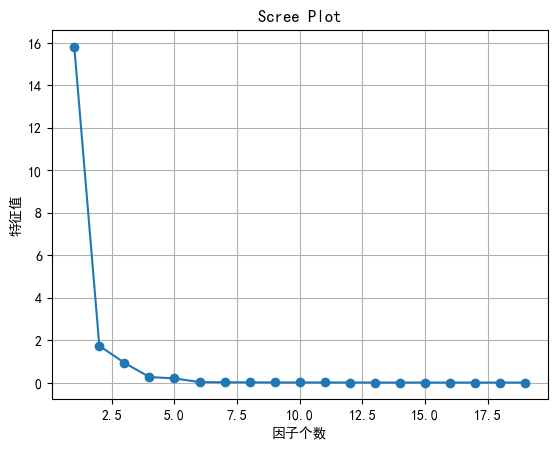

In [8]:
fa = FactorAnalyzer()
fa.fit(X_scaled)

ev, v = fa.get_eigenvalues()
print(ev)
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('因子个数')
plt.ylabel('特征值')
plt.grid()
plt.show()

In [9]:
# 使用“最大方差旋转”让因子更容易解释
fa = FactorAnalyzer(n_factors=3)
# fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X_scaled)

ev, v = fa.get_eigenvalues()
print("特征值：", ev)
print("每个因子解释的方差比例：", ev / ev.sum())

# 查看因子载荷矩阵（每个原始变量在因子上的权重）
loadings = fa.loadings_

# 获取因子载荷矩阵并转化为DataFrame
loadings_df = pd.DataFrame(fa.loadings_, index=country_mean.columns[1:], columns=[f'Factor{i+1}' for i in range(fa.n_factors)])
# 查看结果
print(loadings_df)

特征值： [1.58326765e+01 1.73151845e+00 9.28959843e-01 2.59401594e-01
 1.94132472e-01 2.15213100e-02 1.23724037e-02 8.67896896e-03
 4.53851832e-03 2.72405482e-03 2.04319962e-03 8.40053473e-04
 3.80173413e-04 1.60753893e-04 3.06150651e-05 2.06258943e-05
 4.04280228e-07 1.02197731e-08 3.78002595e-09]
每个因子解释的方差比例： [8.33298765e-01 9.11325501e-02 4.88926233e-02 1.36527155e-02
 1.02174985e-02 1.13270052e-03 6.51179141e-04 4.56787840e-04
 2.38869385e-04 1.43371307e-04 1.07536822e-04 4.42133407e-05
 2.00091270e-05 8.46073121e-06 1.61131922e-06 1.08557339e-06
 2.12779068e-08 5.37882797e-10 1.98948734e-10]
                                                     Factor1   Factor2  \
Population                                         -0.161192  1.067183   
Per capita GNI                                     -0.043629 -0.150495   
Agriculture, hunting, forestry, fishing (ISIC A-B) -0.144205  1.143426   
Construction (ISIC F)                               0.749791  0.269744   
Exports of goods and services 

d:\Anaconda\envs\LRD_GNN\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# 创建一个字典，用来存储排序后的因子表
factor_sorted_dict = {}

# 对每个因子按权重排序，并将其存储为一个单独的表
for factor in loadings_df.columns:
    # 按照每个因子的载荷（绝对值）排序，降序排列
    sorted_factor = loadings_df[[factor]].sort_values(by=factor, ascending=False)
    factor_sorted_dict[factor] = sorted_factor

# 打印排序后的结果（可以选择保存为CSV文件或其他格式）
for factor, sorted_table in factor_sorted_dict.items():
    print(f"\n{factor} 排序后的因子载荷:")
    print(sorted_table)


Factor1 排序后的因子载荷:
                                                     Factor1
Other Activities (ISIC J-P)                         1.162687
Household consumption expenditure (including No...  1.155990
Wholesale, retail trade, restaurants and hotels...  1.109544
Final consumption expenditure                       1.108969
Transport, storage and communication (ISIC I)       1.103519
Total Value Added                                   1.011910
Gross National Income(GNI) in USD                   0.994338
Gross Domestic Product (GDP)                        0.986394
General government final consumption expenditure    0.889679
Construction (ISIC F)                               0.749791
Gross fixed capital formation (including Acquis...  0.698033
Gross capital formation                             0.683047
Mining, Manufacturing, Utilities (ISIC C-E)         0.624080
Imports of goods and services                       0.506768
Manufacturing (ISIC D)                              0.376167
Expor

In [31]:
# 方差解释率
8.33298765e-01+9.11325501e-02+4.88926233e-02

0.9733239384

In [11]:
# 计算因子得分
factor_scores = fa.transform(X_scaled)
factor_scores_df = pd.DataFrame(factor_scores, 
                                index=country_mean['Country'], 
                                columns=["Factor1", "Factor2", "Factor3"])
# factor_scores_df = pd.DataFrame(factor_scores, 
#                                 index=country_mean['Country'], 
#                                 columns=["Factor1", "Factor2"])
factor_scores_df

d:\Anaconda\envs\LRD_GNN\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Factor1,Factor2,Factor3
Country,,,
Afghanistan,-1.124452,-0.622983,0.245140
Albania,-0.334988,-0.564459,-0.491326
Algeria,2.390530,1.041951,0.071227
Andorra,-0.645217,-0.905463,-0.490563
Angola,-0.148243,-0.266109,0.182695
...,...,...,...
Viet Nam,-3.095602,2.071939,7.640521
Yemen,-0.942061,0.084338,0.619605
Zambia,-1.301007,-0.337437,0.347061


In [12]:
def get_factor_scores(df_economy, left_year, right_year, fa,with_year=False):
    X_scaled,country_mean, df_factor = get_X_scale(df_economy=df_economy, left_year=left_year, right_year=right_year, with_year=with_year)
    # factor_scores = fa.transform(X_scaled)
    factor_scores =  np.dot(X_scaled, fa.loadings_)
    factor_scores_df = pd.DataFrame(factor_scores, 
                                index=country_mean['Country'], 
                                columns=["Factor1", "Factor2", "Factor3"])
    return factor_scores_df


In [13]:
factor1_sorted = factor_scores_df.sort_values(by="Factor1", ascending=False)
print("Factor1 排序后的因子得分：")
print(factor1_sorted)

# Factor2 排序后的表格
factor2_sorted = factor_scores_df.sort_values(by="Factor2", ascending=False)
print("\nFactor2 排序后的因子得分：")
print(factor2_sorted)

# Factor3 排序后的表格
factor3_sorted = factor_scores_df.sort_values(by="Factor3", ascending=False)
print("\nFactor3 排序后的因子得分：")
print(factor3_sorted)

Factor1 排序后的因子得分：
                       Factor1    Factor2    Factor3
Country                                             
 Türkiye             24.075008   5.356984 -14.798884
 Brazil              20.010878   0.817268 -11.447434
 Thailand            17.623101   0.609271  -8.260016
 Spain               16.317835  32.496190  19.102267
 United States       13.789720   5.312902   5.856487
...                        ...        ...        ...
 Canada             -12.655782  -9.123233   0.573994
 Mexico             -13.596183 -14.966084 -17.039864
 Republic of Korea  -16.831569  -2.179644  12.142063
 Italy              -35.826965   3.576216  20.625003
 Nigeria            -39.307242   3.139429  18.466829

[210 rows x 3 columns]

Factor2 排序后的因子得分：
                                Factor1    Factor2    Factor3
Country                                                      
 Spain                        16.317835  32.496190  19.102267
 China                         6.080908  10.661541   1.669171
 I

In [14]:

def plot_factor(factor_scores_df):
    plt.figure(figsize=(12, 8))

    # 散点图
    plt.scatter(factor_scores_df["Factor1"], factor_scores_df["Factor2"], color='skyblue', edgecolors='k')

    # 加标签（只标出极端值，避免太乱）
    for country in factor_scores_df.index:
        x = factor_scores_df.loc[country, "Factor1"]
        y = factor_scores_df.loc[country, "Factor2"]
        # 只标出得分很高或很低的国家
        if abs(x) > 10 or abs(y) > 2.5:
            plt.text(x + 0.3, y + 0.2, country, fontsize=9)

    plt.axhline(0, color='gray', linestyle='--')  # 水平轴
    plt.axvline(0, color='gray', linestyle='--')  # 垂直轴

    plt.title("Factor1 vs Factor2 因子得分散点图", fontsize=16)
    plt.xlabel("Factor1：消费与服务主导", fontsize=12)
    plt.ylabel("Factor2：农业与人口主导", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
get_factor_scores(df_economy=df_economy,left_year=1992,right_year=1992,fa=fa)

,Factor1,Factor2,Factor3
Country,,,
Afghanistan,-2.746450,-0.785674,-0.592937
Albania,-2.749163,-0.963099,-0.560590
Algeria,-1.738394,-0.092971,-0.406085
Andorra,-2.859160,-1.469373,0.875485
Angola,-2.339990,-0.609780,-0.396533
...,...,...,...
Viet Nam,-2.688559,-0.049169,-0.669615
Yemen,-2.699268,-0.844064,-0.585195
Zambia,-2.720779,-0.915098,-0.559751


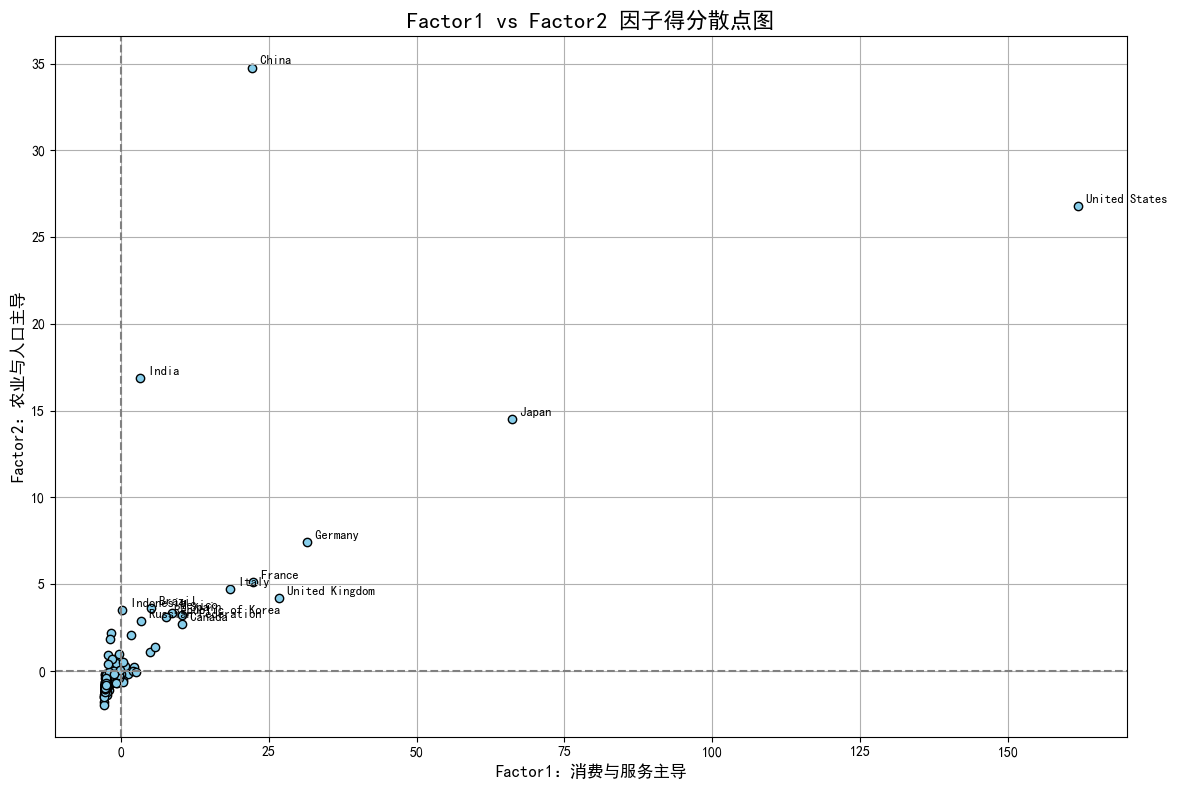

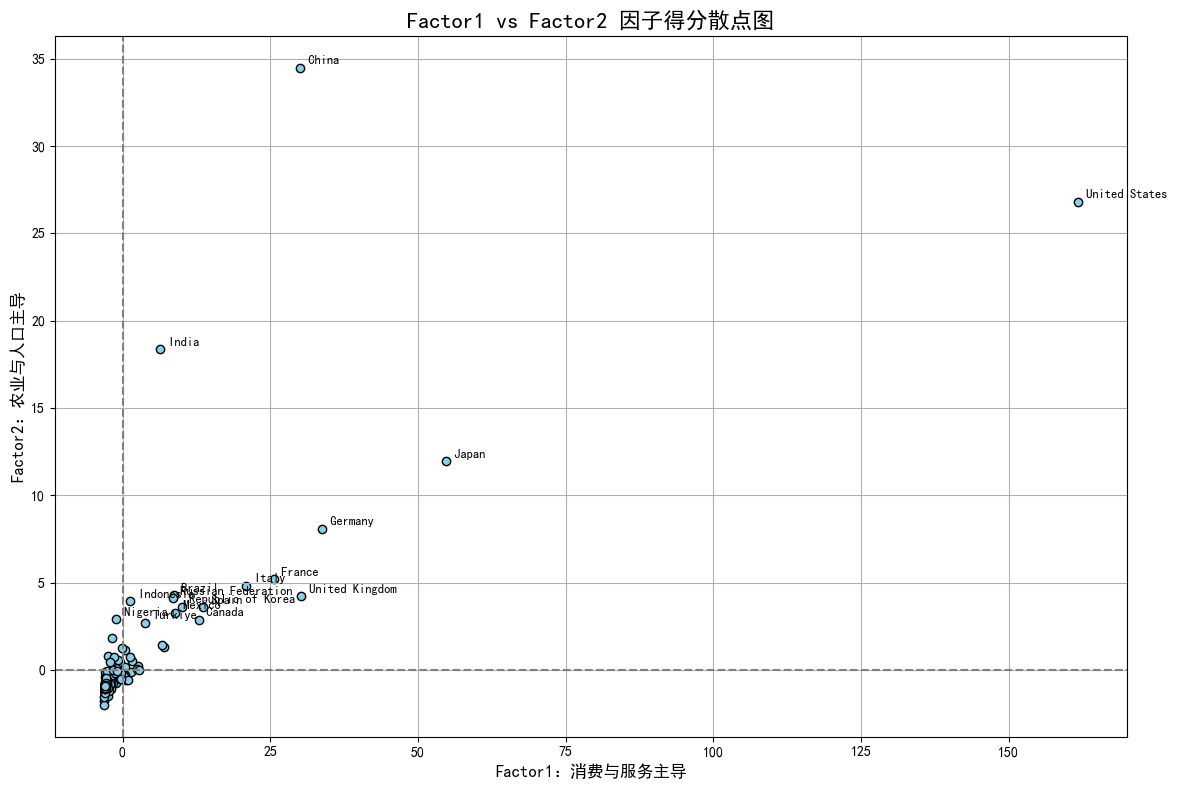

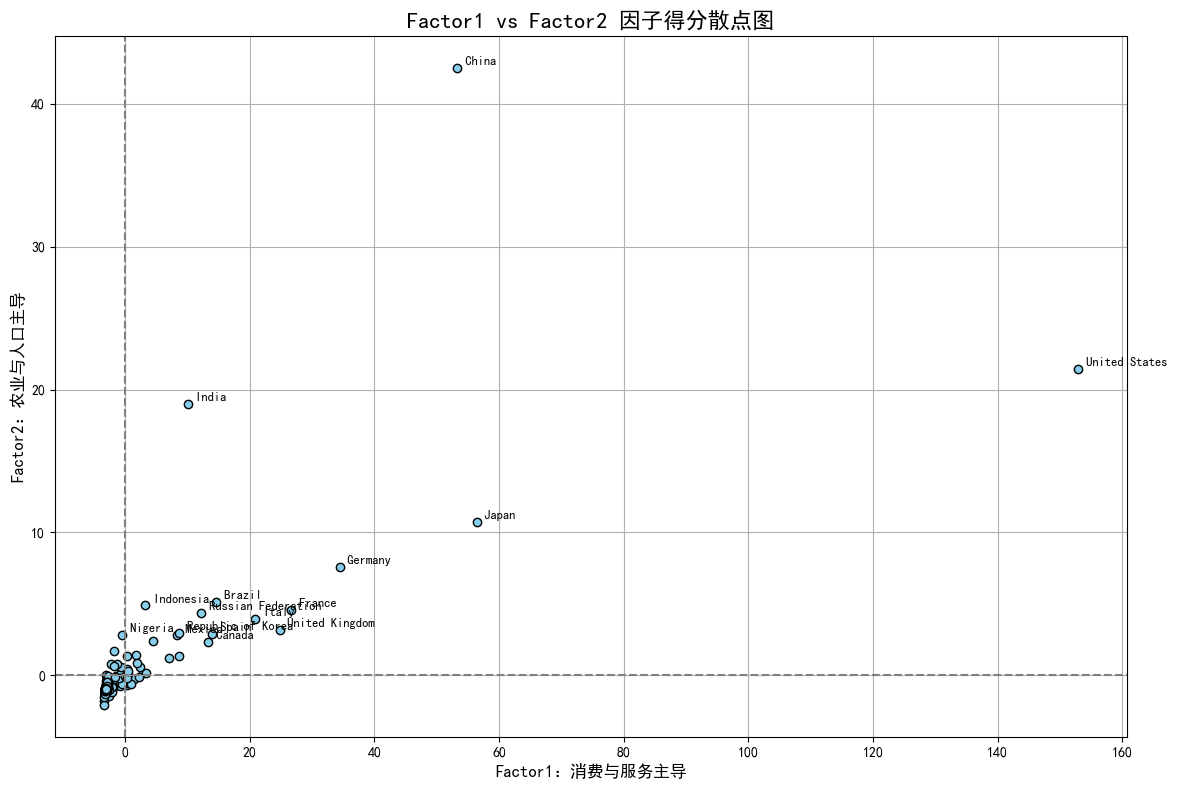

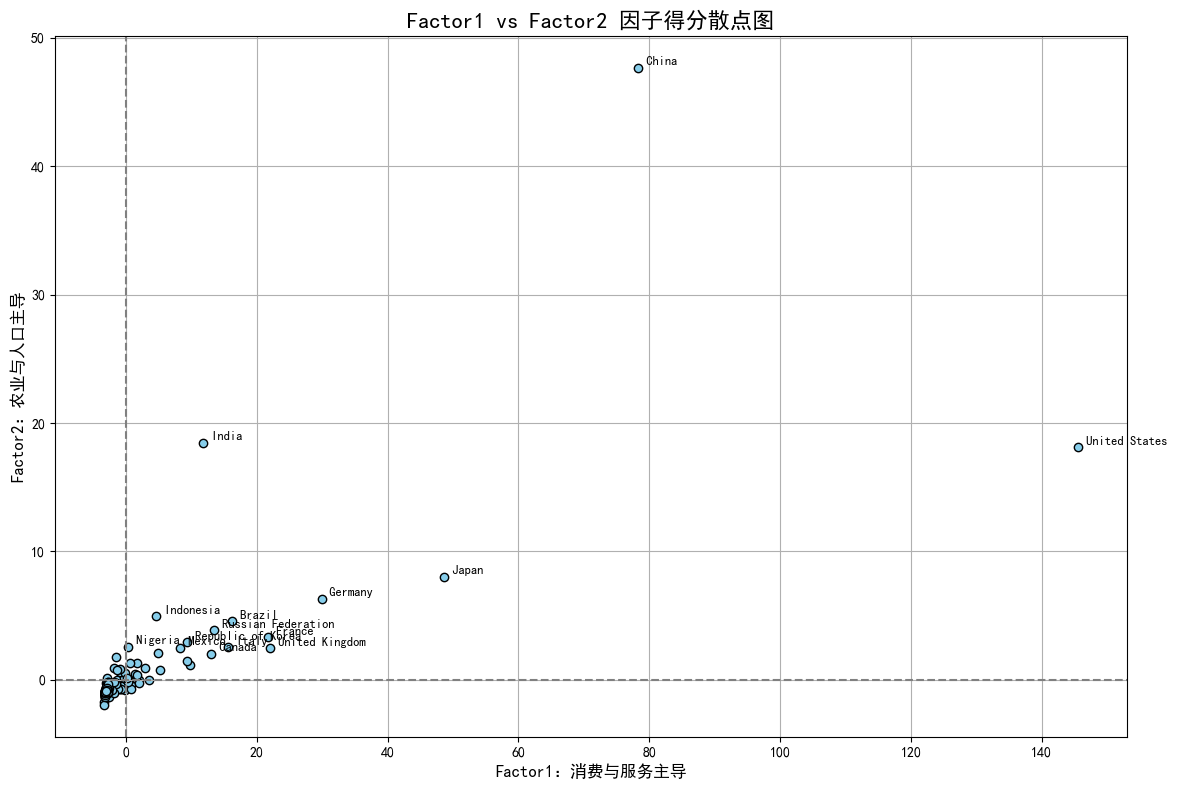

In [16]:
plot_factor(get_factor_scores(df_economy=df_economy,left_year=2000,right_year=2005,fa=fa))
plot_factor(get_factor_scores(df_economy=df_economy,left_year=2005,right_year=2007,fa=fa))
plot_factor(get_factor_scores(df_economy=df_economy,left_year=2008,right_year=2010,fa=fa))
plot_factor(get_factor_scores(df_economy=df_economy,left_year=2010,right_year=2015,fa=fa))
